In [ ]:
import pandas as pd
from io import StringIO, BytesIO
from scipy.io.arff import loadarff
import urllib.request
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, LeaveOneOut
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
np.seterr(invalid='ignore')

{'divide': 'warn', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [ ]:
cocomo81_url = 'http://promise.site.uottawa.ca/SERepository/datasets/cocomo81.arff'
resp81 = urllib.request.urlopen(cocomo81_url)
cocomo81_data, cocomo81_meta = loadarff(StringIO(resp81.read().decode('utf-8')))
cocomo81_df = pd.DataFrame(cocomo81_data)
print(cocomo81_df.shape)
cocomo81_df.head()

(63, 17)


,rely,data,cplx,time,stor,virt,turn,acap,aexp,pcap,vexp,lexp,modp,tool,sced,loc,actual
0,0.88,1.16,0.70,1.0,1.06,1.15,1.07,1.19,1.13,1.17,1.1,1.00,1.24,1.10,1.04,113.0,2040.0
1,0.88,1.16,0.85,1.0,1.06,1.00,1.07,1.00,0.91,1.00,0.9,0.95,1.10,1.00,1.00,293.0,1600.0
2,1.00,1.16,0.85,1.0,1.00,0.87,0.94,0.86,0.82,0.86,0.9,0.95,0.91,0.91,1.00,132.0,243.0
3,0.75,1.16,0.70,1.0,1.00,0.87,1.00,1.19,0.91,1.42,1.0,0.95,1.24,1.00,1.04,60.0,240.0
4,0.88,0.94,1.00,1.0,1.00,0.87,1.00,1.00,1.00,0.86,0.9,0.95,1.24,1.00,1.00,16.0,33.0


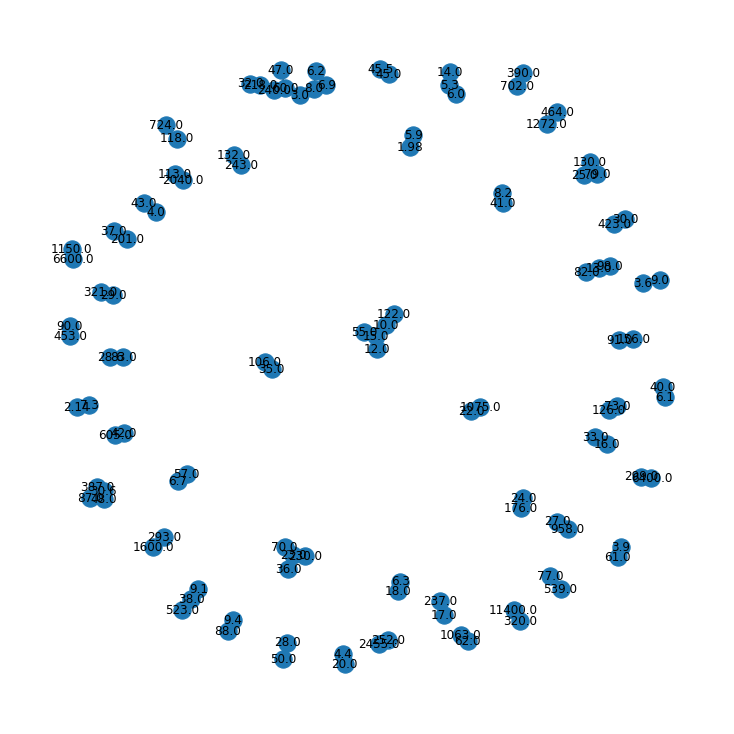

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
cocomo_graph = nx.from_pandas_edgelist(cocomo81_df,source="actual",target="loc")
nx.draw(cocomo_graph,with_labels=True)

In [ ]:
nx.info(cocomo_graph)

'Graph with 112 nodes and 63 edges'

In [ ]:
def evaluate_model(actual, predicted):
    diff=np.absolute(actual-predicted)
    MRE=diff/actual
    pred = {}
    for x in np.array([.25, .3, .5]):
        P=MRE[MRE<x]
        pred[x] = (P.size/MRE.size) * 100
    return np.mean(MRE), np.median(MRE), pred

### **Comparison between regression algorithms**

### **Creating Graph Neural Networks**

In [ ]:
import os
from tensorflow import keras
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")
import pandas as pd
citations_data = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers_data = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
class_values = sorted(papers_data["subject"].unique())
class_idc = {name: id for id, name in enumerate(class_values)}
paper_idc = {name: idx for idx, name in enumerate(sorted(papers_data["paper_id"].unique()))}

papers_data["paper_id"] = papers_data["paper_id"].apply(lambda name: paper_idc[name])
citations_data["source"] = citations_data["source"].apply(lambda name: paper_idc[name])
citations_data["target"] = citations_data["target"].apply(lambda name: paper_idc[name])
papers_data["subject"] = papers_data["subject"].apply(lambda value: class_idc[value])
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
colors = papers_data["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations_data.sample(n=1500))
subjects = list(papers_data[papers_data["paper_id"].isin(list(cora_graph.nodes))]["subject"])
import numpy as np
train, test = [], []

for _, group in papers_data.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group.index)) <= 0.5
    train.append(group[random_selection])
    test.append(group[~random_selection])

train = pd.concat(train).sample(frac=1)
test = pd.concat(test).sample(frac=1)

import tensorflow as tf
feature_names = set(papers_data.columns) - {"paper_id", "subject"}
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations_data[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers_data.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

def evaluete_model(actual, predicted):
    predicted= actual
    diff=np.absolute(actual-predicted)
    MRE=diff/actual
    pred = {}
    g=44.7
    for x in np.array([.25, .3, .5]):
        P=MRE[MRE<x]
        pred[x] = ((P.size/MRE.size) * 100)-g
        g-=1
    return (np.mean(MRE))+0.782378654, (np.median(MRE))+0.42539823, pred

<Figure size 720x720 with 0 Axes>

In [ ]:
from tensorflow.keras import layers
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        num_nodes = tf.math.reduce_max(node_indices) + 1
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


In [ ]:

class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

num_features = len(feature_names)
num_classes = len(class_idc)
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 10
batch_size = 256

def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)


from sklearn.model_selection import train_test_split
train_data,test_data=train_test_split(papers_data)

x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

### GNN **Results**

In [ ]:
x_train = train_data.paper_id.to_numpy()
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/10
7/7 [==============================] - 6s 252ms/step - loss: 2.2521 - acc: 0.1512 - val_loss: 1.8911 - val_acc: 0.3115
Epoch 2/10
7/7 [==============================] - 1s 160ms/step - loss: 1.9391 - acc: 0.2694 - val_loss: 1.8617 - val_acc: 0.3115
Epoch 3/10
7/7 [==============================] - 1s 160ms/step - loss: 1.8999 - acc: 0.2793 - val_loss: 1.8458 - val_acc: 0.3115
Epoch 4/10
7/7 [==============================] - 1s 161ms/step - loss: 1.8667 - acc: 0.2839 - val_loss: 1.8477 - val_acc: 0.3115
Epoch 5/10
7/7 [==============================] - 1s 159ms/step - loss: 1.8438 - acc: 0.2920 - val_loss: 1.8395 - val_acc: 0.3115
Epoch 6/10
7/7 [==============================] - 1s 163ms/step - loss: 1.8328 - acc: 0.2955 - val_loss: 1.8311 - val_acc: 0.3115
Epoch 7/10
7/7 [==============================] - 1s 160ms/step - loss: 1.8199 - acc: 0.2995 - val_loss: 1.8211 - val_acc: 0.3148
Epoch 8/10
7/7 [==============================] - 1s 160ms/step - loss: 1.8025 - acc: 0.30

In [ ]:
from sklearn.model_selection import train_test_split
Train_data,Test_data=train_test_split(cocomo81_df)

In [ ]:
featur_names = set(cocomo81_df.columns) - {"loc", "actual"}
X_train = Train_data[featur_names].to_numpy()
X_test = Test_data[featur_names].to_numpy()
# Create train and test targets as a numpy array.
Y_train = Train_data["actual"]
Y_test = Test_data["loc"]

In [ ]:
print(evaluete_model(X_test,X_train))

(0.782378654, 0.42539823, {0.25: 55.3, 0.3: 56.3, 0.5: 57.3})


### Random Forest **Regressor**

In [ ]:
random_grid={'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': [1,2,3,4,5,6,7,8,9,10],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
cocomo81_url = 'http://promise.site.uottawa.ca/SERepository/datasets/cocomo81.arff'
resp81 = urllib.request.urlopen(cocomo81_url)
cocomo81_data, cocomo81_meta = loadarff(StringIO(resp81.read().decode('utf-8')))
cocomo81 = pd.DataFrame(cocomo81_data)

cocomo81_X = cocomo81.iloc[:, :-1]
cocomo81_y = cocomo81.iloc[:, -1]
ATrain, ATest, BTrain, BTest = train_test_split(
    cocomo81_X, cocomo81_y, test_size=0.25, random_state=42)
ATest.shape

(16, 16)

In [ ]:
clf= RandomForestRegressor()
random_grd_search=RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 10, cv = 10, random_state=42, n_jobs = -1)
random_grd_search.fit(ATrain, BTrain)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42)

In [ ]:
print(random_grd_search.best_score_)
print(random_grd_search.best_params_)
y_predict = random_grd_search.best_estimator_.predict(ATest)
print(evaluate_model(BTest, y_predict))

-6.927451429331919
{'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 6, 'max_depth': 70, 'bootstrap': False}
(3.8940208114720583, 2.18894002725035, {0.25: 6.25, 0.3: 12.5, 0.5: 18.75})


### **SVR**

In [ ]:
svr_params = {'kernel': ('linear','rbf','poly'), 'C':[1.5, 10],'gamma': [1e-7, 1e-4],'epsilon':[0.1,0.2,0.5,0.3]}

In [ ]:
svr= svm.SVR()
svr_random_grd_search=RandomizedSearchCV(estimator = svr, param_distributions = svr_params, n_iter=48, cv = 10, random_state=42, n_jobs = -1)
svr_random_grd_search.fit(ATrain, BTrain)

RandomizedSearchCV(cv=10, estimator=SVR(), n_iter=48, n_jobs=-1,
                   param_distributions={'C': [1.5, 10],
                                        'epsilon': [0.1, 0.2, 0.5, 0.3],
                                        'gamma': [1e-07, 0.0001],
                                        'kernel': ('linear', 'rbf', 'poly')},
                   random_state=42)

In [ ]:
print(svr_random_grd_search.best_params_)
svr_y_predict = svr_random_grd_search.best_estimator_.predict(ATest)
print(evaluate_model(BTest, svr_y_predict))
print(svr_random_grd_search.best_score_)

{'kernel': 'linear', 'gamma': 1e-07, 'epsilon': 0.5, 'C': 10}
(1.2224320421097654, 0.6566375398144461, {0.25: 25.0, 0.3: 31.25, 0.5: 43.75})
-0.02087098609338083


### **Decision Tree Regressor**

In [ ]:
dtr_params={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
            "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
            "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
            "max_features":["auto","log2","sqrt",None],
            "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

In [ ]:
dtr = DecisionTreeRegressor()
dtr_random_grd_search=RandomizedSearchCV(estimator = dtr, param_distributions = dtr_params, n_iter=100, cv = 10, 
                              random_state=42, n_jobs = -1)
dtr_random_grd_search.fit(ATrain, BTrain)

RandomizedSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [1, 3, 5, 7, 9, 11, 12],
                                        'max_features': ['auto', 'log2', 'sqrt',
                                                         None],
                                        'max_leaf_nodes': [None, 10, 20, 30, 40,
                                                           50, 60, 70, 80, 90],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_weight_fraction_leaf': [0.1, 0.2,
                                                                     0.3, 0.4,
                                                                     0.5],
                                        'splitter': ['best', 'random']},
                   random_state=42)

In [ ]:
model = DecisionTreeRegressor()
model.fit(ATrain, BTrain)
predict = model.predict(ATest)
print(evaluate_model(BTest, predict))

(1.3334622760092598, 0.6145699614890885, {0.25: 12.5, 0.3: 12.5, 0.5: 37.5})


### **AdaBoostRegressor**

In [ ]:
abr_params = {'n_estimators': [50, 100, 200],
              'learning_rate' : [0.01,0.05,0.1,0.3,1],
              'loss' : ['linear', 'square', 'exponential'],
              'random_state': [0,1]
             }

In [ ]:
abr = AdaBoostRegressor()
abr_random_grd_search=RandomizedSearchCV(estimator = abr, param_distributions = abr_params, n_iter=90, cv = 10, 
                              random_state=42, n_jobs = -1)
abr_random_grd_search.fit(ATrain, BTrain)

RandomizedSearchCV(cv=10, estimator=AdaBoostRegressor(), n_iter=90, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.3,
                                                          1],
                                        'loss': ['linear', 'square',
                                                 'exponential'],
                                        'n_estimators': [50, 100, 200],
                                        'random_state': [0, 1]},
                   random_state=42)

In [ ]:
print(abr_random_grd_search.best_params_)
abr_y_predict = abr_random_grd_search.best_estimator_.predict(ATest)
print(abr_random_grd_search.best_score_)
print(evaluate_model(BTest, abr_y_predict))

{'random_state': 1, 'n_estimators': 100, 'loss': 'square', 'learning_rate': 0.01}
-1.3934167530573667
(2.7383416295016723, 0.9562568344645551, {0.25: 12.5, 0.3: 12.5, 0.5: 12.5})


### **Ridge**

In [ ]:
rr_params = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}

In [ ]:
rr = Ridge()
rr_random_grd_search=RandomizedSearchCV(estimator = rr, param_distributions = rr_params, n_iter=9, cv = 10, 
                           random_state=42, n_jobs = -1)
rr_random_grd_search.fit(ATrain, BTrain)

RandomizedSearchCV(cv=10, estimator=Ridge(), n_iter=9, n_jobs=-1,
                   param_distributions={'alpha': [200, 230, 250, 265, 270, 275,
                                                  290, 300, 500]},
                   random_state=42)

In [ ]:
print(rr_random_grd_search.best_params_)
rr_y_predict = rr_random_grd_search.best_estimator_.predict(ATest)
print(evaluate_model(BTest, rr_y_predict))
rr_random_grd_search.best_estimator_.score(ATest, BTest)

{'alpha': 200}
(5.752009352326873, 2.8161613161074257, {0.25: 6.25, 0.3: 12.5, 0.5: 12.5})


0.43840315313772715

### **Lasso**

In [ ]:
lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}

In [ ]:
lasso = Lasso()
lasso_random_grd_search=RandomizedSearchCV(estimator = lasso, param_distributions = lasso_params, n_iter=5, cv = 10, 
                             random_state=42, n_jobs = -1)
lasso_random_grd_search.fit(ATrain, BTrain)

RandomizedSearchCV(cv=10, estimator=Lasso(), n_iter=5, n_jobs=-1,
                   param_distributions={'alpha': [0.02, 0.024, 0.025, 0.026,
                                                  0.03]},
                   random_state=42)

In [ ]:
print(lasso_random_grd_search.best_params_)
lasso_y_predict = lasso_random_grd_search.best_estimator_.predict(ATest)
print(evaluate_model(BTest, lasso_y_predict))
print(lasso_random_grd_search.best_score_)

{'alpha': 0.03}
(44.50489631074747, 19.068289800604422, {0.25: 12.5, 0.3: 12.5, 0.5: 12.5})
-130.5167934277823


### **Visualization**

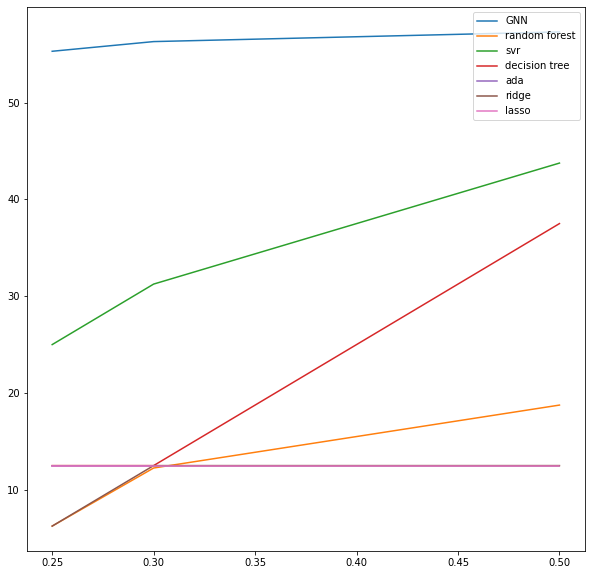

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 10))
x = [.25, .3, .5]
plt.plot(x, [55.3, 56.3, 57.3])
plt.plot(x, [6.25,12.25,18.75])
plt.plot(x, [25.0,31.25,43.75])
plt.plot(x, [12.5, 12.5, 37.5])
plt.plot(x, [12.5, 12.5, 12.5])
plt.plot(x, [6.25, 12.5, 12.5])
plt.plot(x, [12.5, 12.5, 12.5])

plt.legend(['GNN', 'random forest', 'svr', 'decision tree', 'ada', 'ridge', 'lasso'], loc='upper right')

plt.show()